# Bias

* Bias in GAN

1. Differenct kinds of bias in terms of demographic parity, equality od odds, and equality of opportunity
2. Use a classifier to try and detct biases in a GAN by analyzing the generator's implicit associations

In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        # unsample the input 
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

# n_samples, dim of the noise vector
def get_noise(n_samples, z_dim, device='cpu'):
    
    return torch.randn(n_samples, z_dim, device=device)

In [4]:
# map input images to class predictions. 
class Classifier(nn.Module): # classify images into different categories 
 
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels), # to stabilize the training process 
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
       
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1) # flattening 

Parameters

In [5]:
z_dim = 64
batch_size = 128
device = 'cuda'

In [6]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
# training a classifier NN using celebA dataset
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # target all the classes, so that's how many the classifier will learn
    label_indices = range(40) # list of indices representing the classes to be predicted

    n_epochs = 3
    display_step = 500
    lr = 0.001
    # param of Adam optimizer
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    classifier_val_losses = []
    
    '''Training Loop'''
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader): # for each batch of real images and labels in dataloader
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keeping track of the average classifier loss


            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1
            
train_classifier("myfile")

In [9]:

gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40

classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Feature Correlation

In [10]:
n_images = 256
fake_image_history = []
classification_history = []
grad_steps = 30 # gradient steps to take
skip = 2 #  gradient steps to skip in the visualization


feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

n_features = len(feature_names)

target_feature = "Male" # target feature
target_indices = feature_names.index(target_feature) # getting the index

noise = get_noise(n_images, z_dim).to(device)
# marked for gradient computation. Will be modified to control the target feature 
new_noise = noise.clone().requires_grad_() # clone() creates a deep copy of the tensor

starting_classifications = classifier(gen(new_noise)).cpu().detach()

'''Process to modify a noise tensor to control the presence or absence of a specific feature in the generated images'''
# Additive direction (more of a feature)
'''To increase the feature presence'''
for i in range(grad_steps): 
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    
    # computes the mean of the target feature's predicted probability across all generated images
    fake_classes = classifications[:, target_indices].mean() 
    fake_classes.backward() # computes the gradient for the mean prob indicating how to modify the noise tensor to increase the presence of the target
    # grads are added n order to update it
    new_noise.data += new_noise.grad / grad_steps


# Subtractive direction (less of a feature)
'''To decrease the feature presence'''
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]

    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps

classification_history = torch.stack(classification_history) # (2*grad_steps, n_images, n_features)

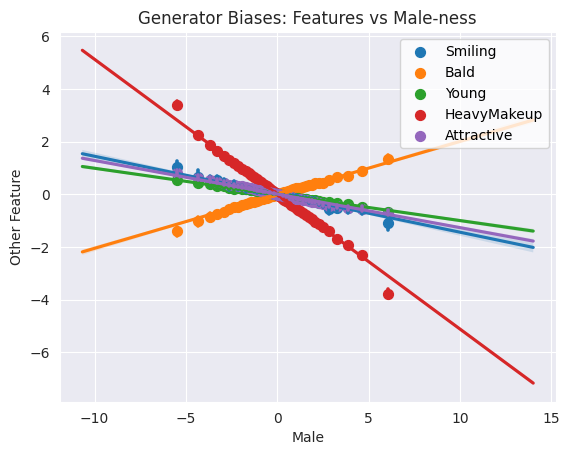

In [11]:
import seaborn as sns # entangled relationships 
'''To analyze the relationships between changes in target feature and changes in othr specified feature.'''
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive"]
# computes the changes in classification probabilities 
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()

for other_feature in other_features:
    other_indices = feature_names.index(other_feature) # index
    with sns.axes_style("darkgrid"):
        sns.regplot( # regression plot 
            x=classification_changes[:, :, target_indices].reshape(-1), # 1-D array
            y=classification_changes[:, :, other_indices].reshape(-1), 
            fit_reg=True, # adds a regression line to the plot
            truncate=True, # datapoints outside the plot limits are not shown 
            ci=99, # confidence interval for line
            x_ci=99, # confidence interval for the x-values 
            x_bins=len(classification_history), # no of bins in the x axis
            label=other_feature # label 
        )
        
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

## Qunatification

In [15]:
from torch.distributions import MultivariateNormal

# cal cov matrix 
def covariance_matrix_from_examples(examples):
    return np.cov(examples.reshape(-1, examples.shape[2]), rowvar=False)


mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, -5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [-5, 4, 2, 11]]
)
samples = MultivariateNormal(mean, covariance).sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1]).numpy()
assert np.all(np.abs(covariance_matrix_from_examples(foo) - covariance.numpy()) < 0.5)


covariance_matrix_from_examples works!


In [16]:
# to get indices by magnitude 
def get_top_magnitude_indices(values):
    top_indices = np.abs(values).argsort()[::-1] # reverse the array of indices to sort values in descending order
    return top_indices


assert get_top_magnitude_indices([3, 2, 1, 0]).tolist() == [0, 1, 2, 3]
assert get_top_magnitude_indices([-2, 0, 1]).tolist() == [0, 2, 1]

get_top_magnitude_indices works!


In [18]:
def remove_from_list(indices, index_to_remove):
    
    
    new_indices = np.delete(indices, np.where(indices ==index_to_remove))
    return new_indices

assert remove_from_list(np.array([3, 2, 1, 0]), 1).tolist() == [3, 2, 0]


In [20]:

def get_top_covariances(classification_changes, target_index, top_n=10):

    cov_matrix = covariance_matrix_from_examples(classification_changes)
    relevant_indices = get_top_magnitude_indices(cov_matrix[target_index, :])
    relevant_indices = remove_from_list(relevant_indices, target_index)
    relevant_indices = relevant_indices[:top_n]

    highest_covariances = cov_matrix[:, relevant_indices][target_index]

    return relevant_indices, highest_covariances

In [ ]:
relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print(relevant_indices)
assert relevant_indices[9] == 34
assert len(relevant_indices) == 10
assert highest_covariances[8] - (-1.2418) < 1e-3
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")